### 1. Accuracy (정확도)

In [1]:
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator # 가장 기본 추정기

In [2]:
# 간단 분류 알고리즘 클래스 생성
# 간단한 알고리듬이지만 정확도만 가지고 성능평가하면 안된다.
class MyDummyClf(BaseEstimator):
#     pass # 재사용
    # fit() 메소드를 정의(선언) : 아무것도 안한다.
    # X : 학습데이터, y : 학습데이터 답
    def fit(self, X, y=None):  
        pass
    
    # X : 예측할 테스트 데이터 , 타이타닉 데이터프레임
    def predict(self, X):
        # np.zeros() => ndarray 생성 , 0으로 채운다
        pred = np.zeros((X.shape[0],1)) # X를 저장할 수 있는 공간
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1
        return pred

In [3]:
# Age, Cabin, Embarked, Fare => Null 처리 함수 
# DataFrame object => fillna() method
def fillna_df(df):
    '''Age => mean()'''
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    
    return df

In [4]:
# 불필요한 컬럼 제거 function
def drop_features(df):
    df.drop(['PassengerId','Name','Ticket']
            , axis=1
            , inplace=True
           )
    return df

In [5]:
# Cabin, Sex, Embarked 레이블 인코딩 함수
# Cabin : C85 => C => 레이블 인코딩 진행 필요
from sklearn.preprocessing import LabelEncoder

def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1] # Cabin : C85 => C 
    features=['Cabin','Sex','Embarked']
    
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    
    return df

In [6]:
# 앞에서 선언한 함수를 다 적용하는 함수
def transform_features(df):
    df = fillna_df(df) # Null 채우기
    df = drop_features(df) # 필요없는 컬럼 삭제
    df = format_features(df) # 인코딩 
    return df

In [7]:
# MyDummyClf class => 성능 평가
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 데이터 로딩
titanic_df = pd.read_csv('../data/titanic_train.csv')

# 데이터와 답을 분리
y_tit_df = titanic_df['Survived'] # 답
X_tit_df = titanic_df.drop('Survived', axis=1) # 데이터

# 데이터 전처리
X_tit_df = transform_features(X_tit_df)

# 학습데이터와 테스트데이터 분리
X_train, X_test, y_train, y_test=\
train_test_split(
      X_tit_df # 분리할 데이터 (학습할 데이터/테스트할 데이터) 
    , y_tit_df # 분리할 답 (학습할 답 / 테스트 답)
    , test_size=0.2
    , random_state=0
)

# 1. 모델 객체 생성
myclf = MyDummyClf()

# 2. 학습
myclf.fit(X_train, y_train)

# 3. 예측값 추출
mypred = myclf.predict(X_test)

# 4. 정확도 출력
accuracy_score(y_test, mypred)

0.7877094972067039

#### 불균형한 데이터 정확도 예측, 성능 평가

In [8]:
# 0 ~ 9 값을 임의 데이터 생성하는 함수
from sklearn.datasets import load_digits 

digits = load_digits()

In [9]:
len(digits.target) # 0 ~ 9 까지 숫자 저장

1797

In [10]:
digits_Ser = pd.Series(digits.target)

In [11]:
digits_Ser.value_counts()

3    183
5    182
1    182
6    181
4    181
9    180
7    179
0    178
2    177
8    174
dtype: int64

In [12]:
# 불규형 데이터 생성
y = (digits.target == 7).astype(int)
# digits.target == 7 => True.astype(int) => 1
# 
# digits.target != 7 => False.astype(int) => 0

In [13]:
# 데이터와 답을 학습데이터와 테스트데이터를 분리 
# 데이터 : digists.data
# 답 : y (불규형 데이터)
X_train, X_test, y_train, y_test = \
train_test_split(
      digits.data # 전체 데이터 
    , y           # 전체 답
    , random_state=0
)

In [14]:
type(y_test)

numpy.ndarray

In [15]:
# 불규형한 레이블 데이터 분포
print('레이블 테스트 세트 크기', y_test.shape)
print('테스트 세트의 레이블 분포값')
print(pd.Series(y_test).value_counts())

레이블 테스트 세트 크기 (450,)
테스트 세트의 레이블 분포값
0    402
1     48
dtype: int64


In [16]:
class MyFakeClf(BaseEstimator):
    def fit(self, X, y): #학습 X
        pass
    
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)

In [17]:
# 모델 생성, 학습 , 예측, 평가
fakeclf = MyFakeClf()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
accuracy_score(y_test, fakepred)

0.8933333333333333

### 2. Confusion Matrix(오차 행렬)

In [18]:
from sklearn.metrics import confusion_matrix

# y_test : 실제 답 , fakepred : 예측 값
confusion_matrix(y_test, fakepred)

array([[402,   0],
       [ 48,   0]], dtype=int64)

### 3. 정밀도, 재현율

In [19]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

In [24]:
# 결과 : 정확도, 오차행렬, 정밀도, 재현율
# 파라미터(재료) : 원래답(y_test), 예측값(pred)
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred) # 오차행렬
    accu = accuracy_score(y_test, pred) # 정확도
    precision = precision_score(y_test, pred) # 정밀도
    recall = recall_score(y_test, pred) # 재현율
    print('오차 행렬')
    print(confusion)
    result = '정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}'
    print(result.format(accu, precision, recall))

In [21]:
# LogisticRegression(이진분류 알고리즘)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [22]:
# 타이타닉 데이터 로딩, 데이터 가공, 데이터 분리
titanic_df = pd.read_csv('../data/titanic_train.csv')

# 답 데이터 추출
y_tit_df = titanic_df['Survived']

# 답을 제외한 데이터 추출
X_tit_df = titanic_df.drop('Survived', axis=1)

# 데이터 가공(전처리)
X_tit_df = transform_features(X_tit_df)

# 데이터 분리(학습, 테스트)
X_train, X_test, y_train, y_test = \
train_test_split(
      X_tit_df
    , y_tit_df
    , test_size=0.2
    , random_state=0
)

In [25]:
# 모델 생성, 학습, 예측, 평가
# 모델 생성
lr_clf = LogisticRegression()

# 학습
lr_clf.fit(X_train, y_train)

# 예측
pred = lr_clf.predict(X_test)

# 평가
get_clf_eval(y_test, pred)

오차 행렬
[[92 18]
 [16 53]]
정확도 : 0.8101, 정밀도 : 0.7465, 재현율 : 0.7681


C:\Users\TJ\anaconda3\envs\ml01-02\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [27]:
y_test.value_counts()

0    110
1     69
Name: Survived, dtype: int64

#### 정밀도와 재현율의 트레이드오프

In [28]:
len(X_test)

179

In [29]:
# 학습한 객체 : lr_clf
# 179 X 2 ndarray return
pred_proba = lr_clf.predict_proba(X_test)

In [35]:
X_test.head(2)

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
495,3,1,29.699118,0,0,14.4583,7,0
648,3,1,29.699118,0,0,7.5500,7,3


In [36]:
pred_proba[1]

array([0.89246256, 0.10753744])

In [37]:
pred = lr_clf.predict(X_test)

In [42]:
pred[0]

0

In [41]:
pred_proba_result = \
np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
pred_proba_result[:10]

array([[0.85141076, 0.14858924, 0.        ],
       [0.89246256, 0.10753744, 0.        ],
       [0.93366403, 0.06633597, 0.        ],
       [0.05373585, 0.94626415, 1.        ],
       [0.31284875, 0.68715125, 1.        ],
       [0.49150729, 0.50849271, 1.        ],
       [0.08232064, 0.91767936, 1.        ],
       [0.06478193, 0.93521807, 1.        ],
       [0.41411799, 0.58588201, 1.        ],
       [0.2914763 , 0.7085237 , 1.        ]])

In [46]:
from sklearn.preprocessing import Binarizer

bina = Binarizer(threshold=38)

X = [
      [36.5, 35, 38.5]
    , [36.5, 36.5, 36.5]
    , [36.5, 39, 36.5]
]

bina.fit_transform(X)

array([[0., 0., 1.],
       [0., 0., 0.],
       [0., 1., 0.]])

In [49]:
# 임계값 설정
custom_threshold = 0.5

# [:, 1] => [행, 열]
# 확률값의 두번째 컬럼(Positive) 추출, 2차원 변경
pred_proba_1 = pred_proba[:,1].reshape(-1,1)
pred_proba_1[:2]

array([[0.14858924],
       [0.10753744]])

In [50]:
# 학습 
bina = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
# 변경
cust_pred = bina.transform(pred_proba_1)
cust_pred[:5]

array([[0.],
       [0.],
       [0.],
       [1.],
       [1.]])

In [51]:
print(cust_pred[:5])

[[0.]
 [0.]
 [0.]
 [1.]
 [1.]]


In [52]:
# 임계값 설정
# custom_threshold = 0.5
get_clf_eval(y_test, cust_pred)

오차 행렬
[[92 18]
 [16 53]]
정확도 : 0.8101, 정밀도 : 0.7465, 재현율 : 0.7681


cust_th = 0.4
오차 행렬
[[86 24]
 [13 56]]
정확도 : 0.7933, 정밀도 : 0.7000, 재현율 : 0.8116

In [53]:
# 임계값 설정
custom_threshold = 0.4

# [:, 1] => [행, 열]
# 확률값의 두번째 컬럼(Positive) 추출, 2차원 변경
pred_proba_1 = pred_proba[:,1].reshape(-1,1)
pred_proba_1[:2]

# 학습 
bina = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
# 변경
cust_pred = bina.transform(pred_proba_1)

# 임계값 설정
# custom_threshold = 0.4
get_clf_eval(y_test, cust_pred)

오차 행렬
[[86 24]
 [13 56]]
정확도 : 0.7933, 정밀도 : 0.7000, 재현율 : 0.8116


In [54]:
def get_eval_by_threshold(y_test, pred_proba_p, thresholds):
    '''
    y_test : 원래답
    pred_proba_p : 결과 확률값
    thresholds : 임계값 리스트
    '''
    for cust_th in thresholds:
        bina = Binarizer(threshold=cust_th).fit(pred_proba_p)
        cust_pred = bina.transform(pred_proba_p)
        print('현재 임계값 : ' , cust_th)
        get_clf_eval(y_test, cust_pred)


In [55]:
# 테스트를 수행할 임계값을 리스트 객체에 저장
thresholds = [0.4,0.45,0.50,0.55,0.60]
pred_proba_2 = pred_proba[:,1].reshape(-1,1)

get_eval_by_threshold(y_test, pred_proba_2, thresholds)

현재 임계값 :  0.4
오차 행렬
[[86 24]
 [13 56]]
정확도 : 0.7933, 정밀도 : 0.7000, 재현율 : 0.8116
현재 임계값 :  0.45
오차 행렬
[[91 19]
 [14 55]]
정확도 : 0.8156, 정밀도 : 0.7432, 재현율 : 0.7971
현재 임계값 :  0.5
오차 행렬
[[92 18]
 [16 53]]
정확도 : 0.8101, 정밀도 : 0.7465, 재현율 : 0.7681
현재 임계값 :  0.55
오차 행렬
[[97 13]
 [18 51]]
정확도 : 0.8268, 정밀도 : 0.7969, 재현율 : 0.7391
현재 임계값 :  0.6
오차 행렬
[[99 11]
 [25 44]]
정확도 : 0.7989, 정밀도 : 0.8000, 재현율 : 0.6377


In [56]:
from sklearn.metrics import precision_recall_curve

# 답이 1일때의 예측 확률 추출
pred_proba_v = lr_clf.predict_proba(X_test)[:,1]

# 데스트데이터 답(y_test), 예측확률(pred_proba_v)
precisions, recalls, thresholds = \
precision_recall_curve(y_test, pred_proba_v)

In [58]:
len(y_test), len(thresholds)

(179, 166)

In [59]:
thresholds

array([0.05935051, 0.06376036, 0.06633597, 0.06808817, 0.07005078,
       0.0710077 , 0.07200104, 0.07715551, 0.08391321, 0.08571234,
       0.08689512, 0.08768603, 0.09034097, 0.09098754, 0.09485004,
       0.09632812, 0.09849203, 0.10077764, 0.10476162, 0.10749675,
       0.10753744, 0.10758436, 0.10760528, 0.10768844, 0.10789315,
       0.10848383, 0.10967401, 0.11047309, 0.11093682, 0.11435931,
       0.11499572, 0.11965973, 0.11966159, 0.11976709, 0.12832907,
       0.13066187, 0.13090169, 0.13244761, 0.13332936, 0.13834394,
       0.13857506, 0.14255055, 0.14351297, 0.1473005 , 0.14730125,
       0.14858924, 0.14889776, 0.14910972, 0.1545143 , 0.15646133,
       0.15969147, 0.16004058, 0.16006988, 0.16820701, 0.1689521 ,
       0.17203423, 0.17225987, 0.17438049, 0.17688836, 0.17803017,
       0.19195742, 0.19363802, 0.20169175, 0.20529746, 0.20734927,
       0.22469532, 0.2281387 , 0.22910895, 0.23591941, 0.23670451,
       0.24391782, 0.24457006, 0.24726041, 0.26004118, 0.26905

In [60]:
thresholds.shape

(166,)

In [61]:
# 반환된 임계값이 166건 => 10건 추출
thr_index = np.arange(0, thresholds.shape[0], 16)
thr_index

array([  0,  16,  32,  48,  64,  80,  96, 112, 128, 144, 160])

In [62]:
# 정밀도 : precisions
precisions[thr_index]

array([0.39884393, 0.42038217, 0.47058824, 0.53781513, 0.61764706,
       0.6744186 , 0.74285714, 0.81481481, 0.89473684, 1.        ,
       1.        ])

In [63]:
recalls[thr_index]

array([1.        , 0.95652174, 0.92753623, 0.92753623, 0.91304348,
       0.84057971, 0.75362319, 0.63768116, 0.49275362, 0.31884058,
       0.08695652])

In [64]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

In [69]:
# precision_recall_curve 함수 : 시각화
def precision_recall_curve_plot(y_test, pred_proba_p):
    # 데스트데이터 답(y_test), 예측확률(pred_proba_p)
    precisions, recalls, thresholds = \
    precision_recall_curve(y_test, pred_proba_p)
    
    # X축을 threshold값, Y축은 정밀도 값, 재현율 값
    # 정밀도 점선으로 표시
    plt.figure(figsize=(8,6))
    thres_boundary = thresholds.shape[0]
    
    # 정밀도 
    plt.plot(
          thresholds # X축 들어갈 값 : 임계값
        , precisions[0:thres_boundary] # Y 축에 들어갈 값 
        , linestyle='--' # 점선
        , label='precision' # 범례 : precision
    )
    
    # 재현율
    plt.plot(
          thresholds # X축 들어갈 값 : 임계값
        , recalls[0:thres_boundary] # Y 축에 들어갈 값 
#         , linestyle='--' # 점선
        , label='recall' # 범례 : recall
    )
    # X축의 Scale을 0.1 단위로 변경
    # X축의 범위값을 가지고 함수 : xlim()
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # y축 라벨, X축 라벨
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    
    # 범례
    plt.legend()
    
    # 그리드 
    plt.grid()
    plt.show()

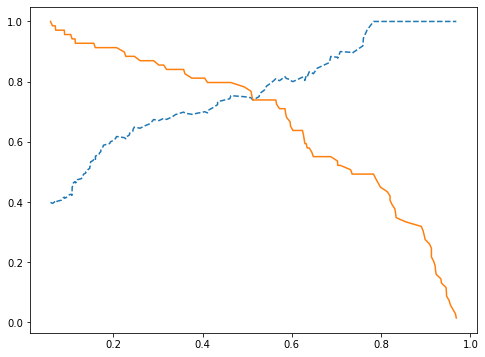

In [66]:
precision_recall_curve_plot(
    y_test
    , lr_clf.predict_proba(X_test)[:,1]
)

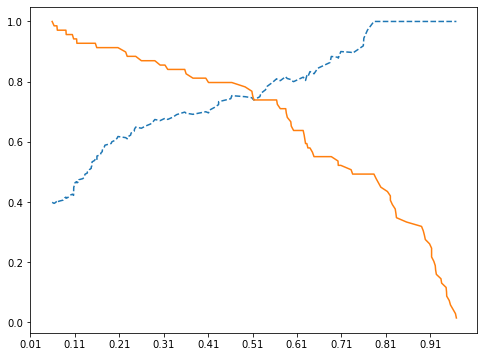

In [68]:
precision_recall_curve_plot(
    y_test
    , lr_clf.predict_proba(X_test)[:,1]
)

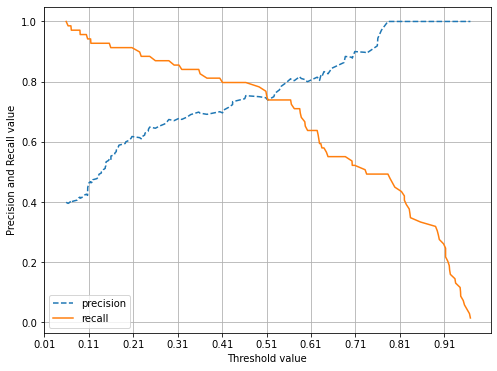

In [70]:
precision_recall_curve_plot(
    y_test
    , lr_clf.predict_proba(X_test)[:,1]
)

### F1 score

In [71]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, pred)
f1

0.7571428571428571

In [72]:
# 결과 : 정확도, 오차행렬, 정밀도, 재현율
# 파라미터(재료) : 원래답(y_test), 예측값(pred)
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred) # 오차행렬
    accu = accuracy_score(y_test, pred) # 정확도
    precision = precision_score(y_test, pred) # 정밀도
    recall = recall_score(y_test, pred) # 재현율
    
    # F1-Score
    f1 = f1_score(y_test, pred)
    
    print('오차 행렬')
    print(confusion)
    result = '정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}, F1 : {3:.4f}'
    print(result.format(accu, precision, recall, f1))

In [73]:
thresholds = [0.4,0.45,0.50,0.55,0.60]
pred_proba = lr_clf.predict_proba(X_test)[:,1].reshape(-1,1)

get_eval_by_threshold(y_test, pred_proba, thresholds)

현재 임계값 :  0.4
오차 행렬
[[86 24]
 [13 56]]
정확도 : 0.7933, 정밀도 : 0.7000, 재현율 : 0.8116, F1 : 0.7517
현재 임계값 :  0.45
오차 행렬
[[91 19]
 [14 55]]
정확도 : 0.8156, 정밀도 : 0.7432, 재현율 : 0.7971, F1 : 0.7692
현재 임계값 :  0.5
오차 행렬
[[92 18]
 [16 53]]
정확도 : 0.8101, 정밀도 : 0.7465, 재현율 : 0.7681, F1 : 0.7571
현재 임계값 :  0.55
오차 행렬
[[97 13]
 [18 51]]
정확도 : 0.8268, 정밀도 : 0.7969, 재현율 : 0.7391, F1 : 0.7669
현재 임계값 :  0.6
오차 행렬
[[99 11]
 [25 44]]
정확도 : 0.7989, 정밀도 : 0.8000, 재현율 : 0.6377, F1 : 0.7097


### ROC Curve and AUC (점수)
- ROC Curve : roc_curve()

In [74]:
from sklearn.metrics import roc_curve

In [75]:
# 1의 예측 확률
pred_proba_v = lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, ths = roc_curve(
      y_test
    , pred_proba_v
)

In [76]:
len(ths)

52

In [77]:
# ROC Curve Chart function
def roc_curve_plot(y_test, pred_proba_p):
    fprs, tprs, ths = \
    roc_curve(y_test, pred_proba_p)
    
    plt.plot(fprs, tprs, label='ROC')
    plt.grid()
    plt.show()

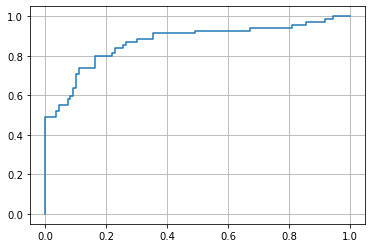

In [79]:
roc_curve_plot(
    y_test
    , pred_proba_v
)

In [80]:
# AUC 
from sklearn.metrics import roc_auc_score

pred = lr_clf.predict(X_test)
roc_score = roc_auc_score(y_test, pred)
roc_score

0.8022397891963109